# Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout, Bidirectional

In [36]:
data = pd.read_csv("data/weatherHistory.csv")
data.head

<bound method NDFrame.head of                       Formatted Date        Summary Precip Type  \
0      2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain   
1      2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain   
2      2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain   
3      2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain   
4      2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain   
...                              ...            ...         ...   
96448  2016-09-09 19:00:00.000 +0200  Partly Cloudy        rain   
96449  2016-09-09 20:00:00.000 +0200  Partly Cloudy        rain   
96450  2016-09-09 21:00:00.000 +0200  Partly Cloudy        rain   
96451  2016-09-09 22:00:00.000 +0200  Partly Cloudy        rain   
96452  2016-09-09 23:00:00.000 +0200  Partly Cloudy        rain   

       Temperature (C)  Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0             9.472222                  7.388889      0.89            14.1197   
1  

In [37]:
data.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')

# __CLEANING__

In [38]:
data.isnull().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [39]:
data['Precip Type'] = data['Precip Type'].replace(np.NaN, 'N/A')
data.isnull().sum()

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

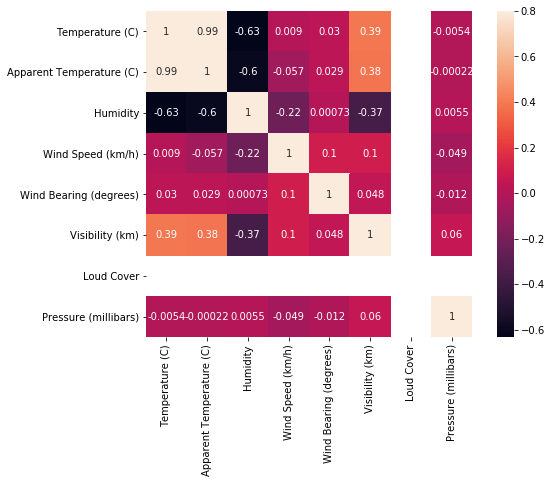

In [40]:

# heat map of correlation of features
correlation_matrix = data.corr()
fig = plt.figure(figsize=(9,6))
sns.heatmap(correlation_matrix,vmax=0.8,square = True, annot= True)
plt.show()

# __SAMPLING__

In [41]:

# *****************************
# HIGHLY IMPORTANT
# *****************************

# Sample data
print("Original Data Stats: \n")
print(data.describe())

print('\n--------\n')

print("New Sample Data Stats: \n")
# all_data['year'].fillna(0).astype(int)
# all_data['mass'].fillna(0).astype(int)


all_data = data.sample(frac=0.1)  # 10% sample set
print(all_data.describe())

Original Data Stats: 

       Temperature (C)  Apparent Temperature (C)      Humidity  \
count     96453.000000              96453.000000  96453.000000   
mean         11.932678                 10.855029      0.734899   
std           9.551546                 10.696847      0.195473   
min         -21.822222                -27.716667      0.000000   
25%           4.688889                  2.311111      0.600000   
50%          12.000000                 12.000000      0.780000   
75%          18.838889                 18.838889      0.890000   
max          39.905556                 39.344444      1.000000   

       Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  Loud Cover  \
count       96453.000000            96453.000000     96453.000000     96453.0   
mean           10.810640              187.509232        10.347325         0.0   
std             6.913571              107.383428         4.192123         0.0   
min             0.000000                0.000000         0

## Get data to train for model 
## Were predicting temperature so using that

In [42]:
temp_data = data.iloc[:,3:4].values #temperature column only
temp_data

array([[ 9.47222222],
       [ 9.35555556],
       [ 9.37777778],
       ...,
       [22.03888889],
       [21.52222222],
       [20.43888889]])

## Min Max Scaling

In [43]:
min_max = MinMaxScaler(feature_range=(0,1))
temp_data = min_max.fit_transform(temp_data)

## Train and Test Data

In [45]:
x_train = []
y_train = []
n_future = 7 # next 4 days temperature forecast
n_past = 30 # Past 30 days 
for i in range(0,len(temp_data)-n_past-n_future+1):
    x_train.append(temp_data[i : i + n_past , 0])     
    y_train.append(temp_data[i + n_past : i + n_past + n_future , 0 ])
x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )

## Build Layers

In [53]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=30, return_sequences=True, input_shape = (x_train.shape[1],1) ) ))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = n_future,activation='linear'))
regressor.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])
regressor.fit(x_train, y_train, epochs=50,batch_size=128 )

Epoch 1/50
754/754 [==============================] - 184s 244ms/step - loss: 0.0143 - acc: 0.1805
Epoch 2/50
754/754 [==============================] - 172s 228ms/step - loss: 0.0050 - acc: 0.3165
Epoch 3/50
754/754 [==============================] - 174s 230ms/step - loss: 0.0036 - acc: 0.3920
Epoch 4/50
754/754 [==============================] - 197s 261ms/step - loss: 0.0030 - acc: 0.4464
Epoch 5/50
754/754 [==============================] - 202s 268ms/step - loss: 0.0027 - acc: 0.4817
Epoch 6/50
754/754 [==============================] - 209s 277ms/step - loss: 0.0025 - acc: 0.5035
Epoch 7/50
754/754 [==============================] - 203s 269ms/step - loss: 0.0024 - acc: 0.5166
Epoch 8/50
754/754 [==============================] - 196s 260ms/step - loss: 0.0024 - acc: 0.5293
Epoch 9/50
754/754 [==============================] - 197s 262ms/step - loss: 0.0023 - acc: 0.5345
Epoch 10/50
754/754 [==============================] - 201s 266ms/step - loss: 0.0023 - acc: 0.5380
Epoch 11/